<div class="alert alert-block alert-success">
<b>Importacion de las librerias</b></div>


In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Diccionario de las categorías
categorias = {
    0: "Árbol",
    1: "Suelo desnudo",
    2: "Pavimento",
    3: "Cuerpo de agua",
    4: "Techo de lámina",
    5: "Techo de losa",
    6: "Arbusto",
    7: "Hierba y pasto seco",
    8: "Hierba y pasto verde",
    9: "Sombra",
    10: "Sin etiqueta"
}


<div class="alert alert-block alert-success">
<b>Ruta de los archivos</b></div>


In [2]:
# Ruta a la carpeta donde están los archivos .csv que van a ser evaluados
ruta_carpeta = "C:/Users/DELL/Documents/tesis/tesis_visual_code/Imagenes_evaluar_desempeño_modelo"


# Lista de archivos etiquetados por el modelo
archivos_caract = [f for f in os.listdir(ruta_carpeta) if f.startswith("Caract_paralelo") and f.endswith("_con_estrategia1.csv")]

Procesando: image_x5_1272

* Reporte de clases predichas erróneamente en 'image_x5_1272':
--------------------------------------------------------
'Hierba y pasto seco' fue predicha pero nunca estuvo en etiquetas reales.
   Se confundió con:
   - Suelo desnudo: 1 veces
   - Techo de losa: 7 veces
   Total de errores para esta clase: 8

'Sombra' fue predicha pero nunca estuvo en etiquetas reales.
   Se confundió con:
   - Árbol: 1 veces
   - Suelo desnudo: 6 veces
   - Pavimento: 2 veces
   - Arbusto: 1 veces
   - Hierba y pasto verde: 3 veces
   - Sin etiqueta: 18 veces
   Total de errores para esta clase: 31

Clases ausentes en ambos archivos:
 - Cuerpo de agua


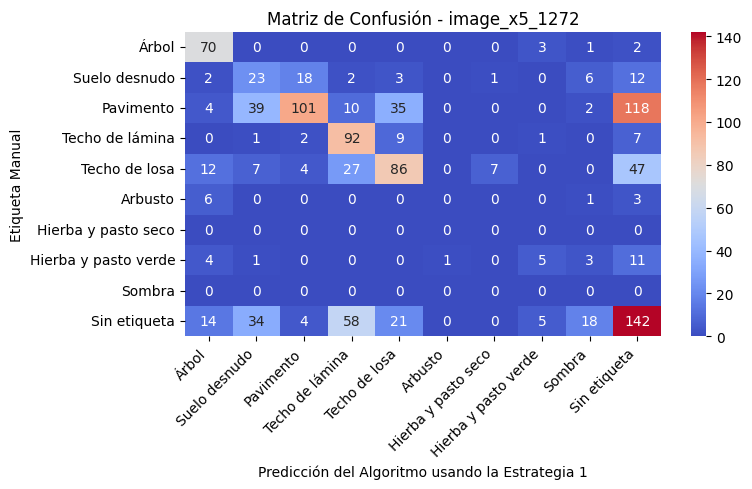

Procesando: image_x5_1730

* Reporte de clases predichas erróneamente en 'image_x5_1730':
--------------------------------------------------------
'Pavimento' fue predicha pero nunca estuvo en etiquetas reales.
   Se confundió con:
   - Cuerpo de agua: 5 veces
   Total de errores para esta clase: 5

'Techo de lámina' fue predicha pero nunca estuvo en etiquetas reales.
   Se confundió con:
   - Suelo desnudo: 2 veces
   - Sin etiqueta: 7 veces
   Total de errores para esta clase: 9

'Hierba y pasto seco' fue predicha pero nunca estuvo en etiquetas reales.
   Se confundió con:
   - Suelo desnudo: 2 veces
   - Sin etiqueta: 2 veces
   Total de errores para esta clase: 4

Clases ausentes en ambos archivos:
 - Techo de losa


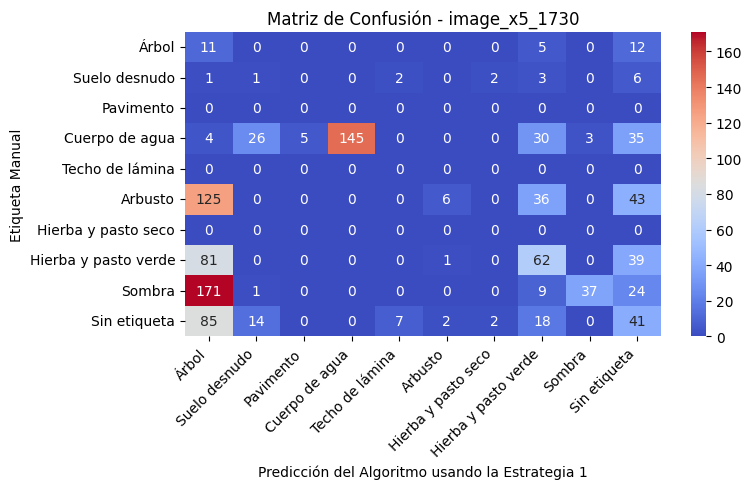

Procesando: image_x5_250

* Reporte de clases predichas erróneamente en 'image_x5_250':
--------------------------------------------------------
'Techo de losa' fue predicha pero nunca estuvo en etiquetas reales.
   Se confundió con:
   - Suelo desnudo: 3 veces
   - Pavimento: 5 veces
   - Techo de lámina: 2 veces
   - Sombra: 12 veces
   - Sin etiqueta: 7 veces
   Total de errores para esta clase: 29

'Hierba y pasto seco' fue predicha pero nunca estuvo en etiquetas reales.
   Se confundió con:
   - Suelo desnudo: 3 veces
   Total de errores para esta clase: 3

Clases ausentes en ambos archivos:
 - Cuerpo de agua


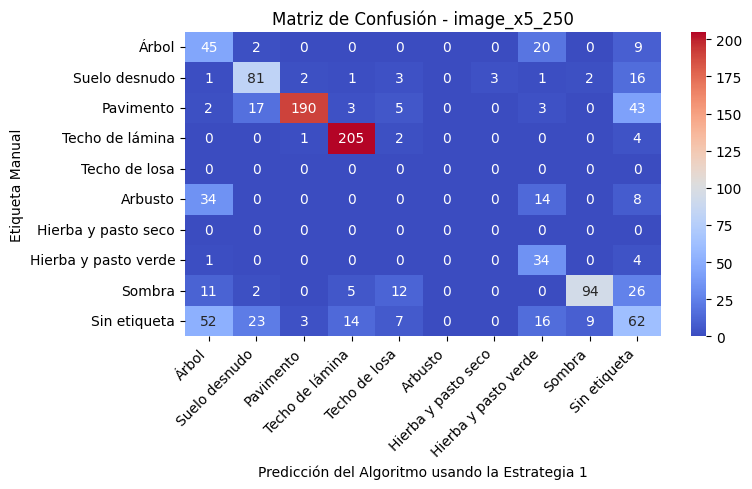

In [3]:

# Listas para almacenar resultados de precisión y errores por imagen
resultados_precision = []
resumen_errores_imagen = []


# Procesar cada imagen seleccionada
for archivo_modelo in archivos_caract:
    nombre_image = archivo_modelo.replace("Caract_paralelo_", "").replace("_con_estrategia1.csv", "")
    archivo_etiquetado = f"Etiquetado_{nombre_image}.csv"

    ruta_modelo = os.path.join(ruta_carpeta, archivo_modelo)
    ruta_manual = os.path.join(ruta_carpeta, archivo_etiquetado)

    if not os.path.exists(ruta_manual):
        print(f" No encontrado el etiquetado manual para: {nombre_image}")
        continue

    print(f"Procesando: {nombre_image}")

    # Cargar las predicciones del modelo y el etiquetado manual
    df_caract = pd.read_csv(ruta_modelo, usecols=["indice", "prediction_actual_dif_estrategia1"])
    df_etiquetado = pd.read_csv(ruta_manual, usecols=["indice", "categoria"])

    #  Asegurar que las columnas 'indice' sean enteros
    #df_caract["indice"] = df_caract["indice"].astype(int)
    #df_etiquetado["indice"] = df_etiquetado["indice"].astype(int)

    # Unir por índice
    df_comparacion = df_etiquetado.merge(df_caract, on="indice", how="left")

    #  CAMBIO: Ya no eliminamos la clase 10
    # df_comparacion = df_comparacion[df_comparacion["Etiqueta_Manual"] != 10]

    # ==========================
    # Definir clases presentes
    # ==========================

    #  CAMBIO: Ya no excluimos 10
    clases_etiquetadas = set(df_comparacion["categoria"].unique())
    clases_predichas = set(df_comparacion["prediction_actual_dif_estrategia1"].unique())
    clases_en_ambos = sorted(clases_etiquetadas.union(clases_predichas))

    # Identificar clases ausentes en ambos archivos
    clases_no_aparecen = []
    clases_a_graficar = []

    for c in categorias.keys():              #  CAMBIO: No excluimos 10
        esta_en_etiquetas = c in clases_etiquetadas
        esta_en_predicciones = c in clases_predichas
        if not esta_en_etiquetas and not esta_en_predicciones:
            clases_no_aparecen.append(categorias[c])
        else:
            clases_a_graficar.append(c)

    # ==========================
    # Calcular matriz de confusión
    # ==========================

    cm = confusion_matrix(
        df_comparacion["categoria"],
        df_comparacion["prediction_actual_dif_estrategia1"],
        labels=clases_a_graficar
    )

    etiquetas_mapeadas = [categorias[c] for c in clases_a_graficar]

    # ==========================
    # Calcular precisión general
    # ==========================

    df_validos = df_comparacion[df_comparacion["categoria"].isin(clases_a_graficar)]
    num_aciertos = (df_validos["categoria"] == df_validos["prediction_actual_dif_estrategia1"]).sum()
    total_superpixeles = len(df_validos)
    precision_general = (num_aciertos / total_superpixeles) * 100 if total_superpixeles > 0 else 0.0

    # ==========================
    # Calcular precisión por categoría
    # ==========================

    precision_por_categoria = {}
    for clase in clases_a_graficar:
        nombre = categorias[clase]
        etiquetas = df_comparacion["categoria"] == clase
        predicciones = df_comparacion["prediction_actual_dif_estrategia1"] == clase

        total_etiquetas = etiquetas.sum()
        aciertos = (etiquetas & predicciones).sum()

        if total_etiquetas > 0:
            precision_por_categoria[nombre] = (aciertos / total_etiquetas) * 100
        else:
            precision_por_categoria[nombre] = np.nan

    resultados_precision.append({
        "Imagen": nombre_image,
        "Precisión General": precision_general,
        **precision_por_categoria
    })

    # ==========================
    # Reporte de errores
    # ==========================

    errores_predicciones = []

    print(f"\n* Reporte de clases predichas erróneamente en '{nombre_image}':")
    print("--------------------------------------------------------")

    for clase_predicha in categorias.keys():
        nombre_clase = categorias[clase_predicha]
        fue_predicha = (df_comparacion["prediction_actual_dif_estrategia1"] == clase_predicha).any()
        existe_en_verdaderas = (df_comparacion["categoria"] == clase_predicha).any()

        if fue_predicha and not existe_en_verdaderas:
            errores_df = df_comparacion[df_comparacion["prediction_actual_dif_estrategia1"] == clase_predicha]
            conteo_confusiones = errores_df["categoria"].value_counts().sort_index()

            print(f"'{nombre_clase}' fue predicha pero nunca estuvo en etiquetas reales.")
            print("   Se confundió con:")
            for clase_real, conteo in conteo_confusiones.items():
                nombre_real = categorias.get(int(clase_real), "Desconocida")
                print(f"   - {nombre_real}: {conteo} veces")
            print(f"   Total de errores para esta clase: {len(errores_df)}\n")

            errores_predicciones.append({
                "Clase_predicha": nombre_clase,
                "ID": clase_predicha,
                "Total_errores": len(errores_df),
                "Confusiones": dict(conteo_confusiones.map(int))
            })

    if clases_no_aparecen:
        print("Clases ausentes en ambos archivos:")
        for clase_nombre in clases_no_aparecen:
            print(f" - {clase_nombre}")

    total_errores_imagen = sum(e["Total_errores"] for e in errores_predicciones)
    resumen_errores_imagen.append({
        "Imagen": nombre_image,
        "Errores_totales_predichos_erróneamente": total_errores_imagen,
        "Clases_ausentes": clases_no_aparecen
    })

    # ==========================
    # Gráfico de matriz de confusión
    # ==========================

    plt.figure(figsize=(8, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm",
                xticklabels=etiquetas_mapeadas,
                yticklabels=etiquetas_mapeadas)
    plt.xlabel("Predicción del Algoritmo usando la Estrategia 1")
    plt.ylabel("Etiqueta Manual")
    plt.title(f"Matriz de Confusión - {nombre_image}")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Crear DataFrames finales
df_precision = pd.DataFrame(resultados_precision)
df_errores = pd.DataFrame(resumen_errores_imagen)



In [4]:
df_precision 


,Imagen,Precisión General,Árbol,Suelo desnudo,Pavimento,Techo de lámina,Techo de losa,Arbusto,Hierba y pasto seco,Hierba y pasto verde,Sombra,Sin etiqueta,Cuerpo de agua
0,image_x5_1272,47.834101,92.105263,34.328358,32.686084,82.142857,45.263158,0.000000,NaN,20.000000,NaN,47.972973,NaN
1,image_x5_1730,27.671233,39.285714,6.666667,NaN,NaN,NaN,2.857143,NaN,33.879781,15.289256,24.260355,58.467742
2,image_x5_250,65.109890,59.210526,73.636364,72.243346,96.698113,NaN,0.000000,NaN,87.179487,62.666667,33.333333,NaN


In [5]:
df_errores 

,Imagen,Errores_totales_predichos_erróneamente,Clases_ausentes
0,image_x5_1272,39,[Cuerpo de agua]
1,image_x5_1730,18,[Techo de losa]
2,image_x5_250,32,[Cuerpo de agua]
